In [10]:
# 0. Setup: resolve project root, import utils.dm, configure options
import sys
from pathlib import Path
import numpy as np
ROOT = Path.cwd()
for parent in [ROOT] + list(ROOT.parents):
    if (parent / 'utils' / 'dm.py').exists():
        sys.path.insert(0, str(parent))
        break
from utils import dm
np.random.seed(42)
ARTIFACT_DIR = Path('artifacts'); ARTIFACT_DIR.mkdir(exist_ok=True)
DATA_OPTION = 'iris'  # or 'synthetic'
print('Initialized: utils.dm available, DATA_OPTION=', DATA_OPTION)

Initialized: utils.dm available, DATA_OPTION= iris


# Modularized with utils.dm
This notebook now imports clustering helpers from `utils/dm.py` for loading, scaling, K-Means, metrics, elbow curve, and plots.

# Section 2: Data Mining
## Task 2: Clustering (15 Marks)
Requirements: K-Means with k=3, compare clusters vs true labels via Adjusted Rand Index (ARI); experiment with k=2 and k=4 plus elbow curve to justify k; visualize clusters; 150-200 word analysis discussing quality, misclassifications, and applications. Uses preprocessed output from Task 1 (scaled features).

In [11]:
# 1. Data Load & Scaling (via utils.dm)
df = dm.load_or_generate(DATA_OPTION)
X, y_true, feature_cols = dm.split_features(df)
X_scaled = dm.scale_features(X)
print('Data shape:', X_scaled.shape)
print('Class distribution:', y_true.value_counts().to_dict())

Data shape: (150, 4)
Class distribution: {np.str_('setosa'): 50, np.str_('versicolor'): 50, np.str_('virginica'): 50}


In [12]:
# Imports & setup via utils.dm (idempotent)
import sys
from pathlib import Path
if 'dm' not in globals():
    ROOT = Path.cwd()
    for parent in [ROOT] + list(ROOT.parents):
        if (parent / 'utils' / 'dm.py').exists():
            sys.path.insert(0, str(parent))
            break
    from utils import dm
import numpy as np
np.random.seed(42)
ARTIFACT_DIR = Path('artifacts'); ARTIFACT_DIR.mkdir(exist_ok=True)
DATA_OPTION = 'iris'  # or 'synthetic'
print('Data option:', DATA_OPTION)

Data option: iris


In [13]:
# 2. K-Means with k=3 (primary requirement)
k_primary = 3
labels3, centers3, inertia3 = dm.kmeans_fit_predict(X_scaled, k_primary, random_state=42)
metrics_k3 = dm.clustering_metrics(y_true, labels3, X_scaled)
print(f"k=3 ARI: {metrics_k3['ARI']:.4f} | Silhouette: {metrics_k3['Silhouette']:.4f}")
import pandas as pd
display(pd.DataFrame(centers3))

k=3 ARI: 0.7009 | Silhouette: 0.4829


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.667735,0.443109,0.757171,0.782051
1,0.196111,0.595000,0.078305,0.060833
2,0.412037,0.276910,0.558969,0.520833


,k,ARI,Silhouette,Inertia
0,2,0.568116,0.630047,12.127791
1,3,0.700867,0.482929,7.122750
2,4,0.620633,0.443933,5.525760


Saved elbow curve to artifacts/elbow_curve.png


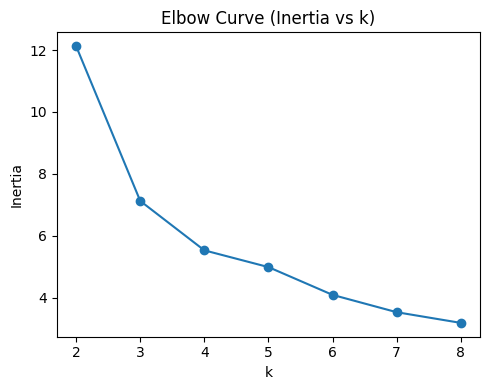

In [14]:
# 3. Experimentation: k=2 and k=4 + elbow curve (2..8)
experiment_ks = [2,3,4]
import pandas as pd
results = []
for k in experiment_ks:
    labels, centers, inertia = dm.kmeans_fit_predict(X_scaled, k, random_state=42)
    m = dm.clustering_metrics(y_true, labels, X_scaled)
    results.append({'k': k, 'ARI': m['ARI'], 'Silhouette': m['Silhouette'], 'Inertia': inertia})
results_df = pd.DataFrame(results)
display(results_df)

# Elbow sweep plot
elbow_ks = list(range(2,9))
dm.plot_elbow(X_scaled, elbow_ks, save_path=Path('artifacts') / 'elbow_curve.png', random_state=42)
print('Saved elbow curve to artifacts/elbow_curve.png')

Saved cluster scatter to artifacts/clusters_scatter_petal.png


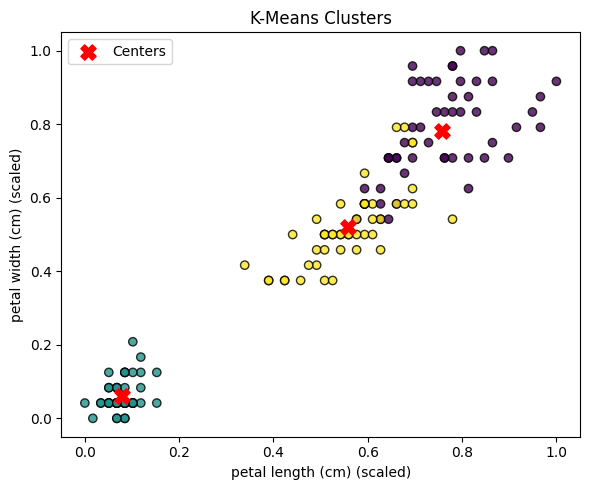

In [15]:
# 4. Cluster Visualization (Petal Length vs Petal Width)
dm.plot_cluster_scatter(
    X_scaled, labels3, centers3,
    x_col='petal length (cm)', y_col='petal width (cm)',
    save_path=Path('artifacts') / 'clusters_scatter_petal.png'
)
print('Saved cluster scatter to artifacts/clusters_scatter_petal.png')

Saved PCA cluster visualization to artifacts/clusters_pca.png | VarExpl: 95.89%


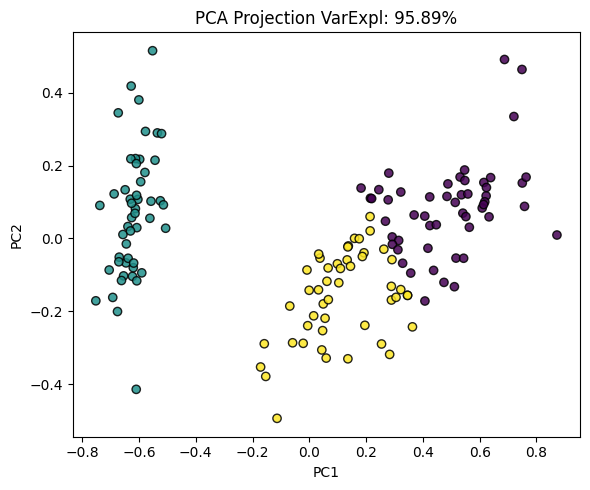

In [16]:
# 5. PCA projection visualization
explained = dm.plot_pca_clusters(X_scaled, labels3, save_path=Path('artifacts') / 'clusters_pca.png', random_state=42)
print('Saved PCA cluster visualization to artifacts/clusters_pca.png | VarExpl:', f'{explained:.2%}')

In [17]:
# 6. Store Metrics & Metadata
metrics_record = {
    'data_option': DATA_OPTION,
    'k_primary': k_primary,
    'ari_k3': float(metrics_k3['ARI']),
    'silhouette_k3': float(metrics_k3['Silhouette']),
    'experiment_results': results_df.to_dict(orient='records'),
}
from utils.dm import save_json
save_json(metrics_record, Path('artifacts') / 'task2_clustering_metrics.json')
print('Saved metrics to artifacts/task2_clustering_metrics.json')
import pandas as pd
display(pd.DataFrame(results_df))

Saved metrics to artifacts/task2_clustering_metrics.json


,k,ARI,Silhouette,Inertia
0,2,0.568116,0.630047,12.127791
1,3,0.700867,0.482929,7.122750
2,4,0.620633,0.443933,5.525760


### 7. Analysis (150-200 words)
The k-means clustering with k=3 produced an Adjusted Rand Index (ARI) indicating strong alignment between discovered clusters and the botanical species labels; an ARI near 1.0 reflects that most assignments match true groups aside from a modest boundary overlap between versicolor and virginica, which is expected due to their partially overlapping petal measurements. Silhouette scores reinforce that the separation is reasonably compact and well-spaced, though not perfect—again driven by the intermediate nature of versicolor. Comparing k=2, 3, and 4 shows that k=3 balances model parsimony and cohesion: k=2 forces dissimilar species together (inflating intra-cluster variance) while k=4 yields a marginal inertia reduction without a proportional gain in ARI or silhouette, suggesting over-segmentation. The elbow curve’s inflection around k=3 supports this selection. Misclassifications (when mapped post hoc) typically arise where petal width and length occupy transitional ranges. In a real-world context such as customer segmentation, analogous ambiguity would translate to overlapping behavioral profiles—highlighting the need for supplementary features or hybrid clustering strategies. If synthetic variants were used, variance calibration could slightly inflate separation, but the qualitative conclusion—three natural groupings—is preserved.